# Kara One - Transduction

## Load Dataset

In [1]:
from lib import KaraOneDataset

dataset_dir = "C:\\Users\\win8t\\OneDrive\\Desktop\\projects\\kara-one-transduction\\p"
dataset = KaraOneDataset(
    dataset_dir,
    start_idx=0,
    end_idx=1,
    n_mel_channels=80,
    eeg_types=["vocal"],
    raw_only=False)

init() end_idx: 1
PATH: C:\Users\win8t\OneDrive\Desktop\projects\kara-one-transduction\p\spoclab/users/szhao/EEG/data/MM05\Acquisition 232 Data.cnt
Reading 0 ... 2477399  =      0.000 ...  2477.399 secs...
EEG_RAW: <RawCNT | Acquisition 232 Data.cnt, 62 x 2477400 (2477.4 s), ~1.14 GB, data loaded>
init-2() end_idx: 1
Calc: 0.722s 0 ['/uw/']
Calc: 0.723s


In [2]:
import numpy as np
i = 0
dataset[i]["eeg_vocal_raw"].shape, dataset[i]["eeg_vocal_feats"].shape, dataset[i]["audio_feats"].shape

((1204, 62), (148, 310), (135, 80))

## Single Channel Analysis

From: [Paper](http://www.cs.toronto.edu/~complingweb/data/karaOne/ZhaoRudzicz15.pdf)

Pearson correlation coefficients between audio features and imagined speech EEG features

|Sensor | FC6    | FT8 |  C5 | CP3|  P3 |
| - | - | - | - | - | - |
|Mean r | 0.3781 | 0.3758 | 0.3728 | 0.3720 | 0.3696 |

| Sensor | T7 | CP5 | C3 | CP1 |C4 |
| - | - | - | - | - | - |
Mean r | 0.3686|  0.3685|  0.3659| 0.3626 |0.3623

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg(eeg_type, target_channels, idx, feat=False):
    plt.rcParams["figure.figsize"] = (14, 9)

    if not target_channels:
        target_channels = dataset.eeg_data.ch_names
    
    print("target_channels:", target_channels)
    
    print(dataset.eeg_data)

    keep_idx_s = [dataset.eeg_data.ch_names.index(target_ch)
                for target_ch in target_channels]

    example = dataset[idx]
    print(example["label"])
    eeg_data = example[eeg_type]
    # eeg_data = eeg_data - eeg_data.mean(axis=1, keepdims=True)
    print("eeg data shape:", eeg_data.shape)

    if feat:
        eeg_data = np.asarray(np.split(eeg_data, 62))
    
    for idx in keep_idx_s:
        print("idx:", idx)
        label = dataset.eeg_data.ch_names[idx]
        if feat:
            data = eeg_data[idx, 16]
        else:
            # data = eeg_data[:903, idx]
            data = eeg_data[:, idx]
            # data = eeg_data[:, (idx*5)+1]
            # data = eeg_data[:, (idx*5)+2] # working (p_r, rms)
        data = data - data.mean(axis=0, keepdims=True)
        # print(eeg_data.shape)
        # print(data.shape, eeg_data.shape, eeg_data.shape[1] / 1000, data)
        print("CUR ELECTRODE DATA:", data.shape)
        plt.plot(data, label=label)
        print(len(data), len(data / max(data)))

    plt.legend(loc="upper left")
    # plt.axvspan(xmin=435, xmax=668, color="green", alpha=0.5)
    # plt.axvspan(xmin=451, xmax=553, color="red", alpha=0.5)
    # plt.axvspan(xmin=397, xmax=532, color="red", alpha=0.5)
    plt.show()

target_channels = "FC6 FT8 C5 CP3 P3 T7 CP5 C3 CP1 C4".split(" ") # top 10
# target_channels = "FC6 FT8 C5 CP3 CP5 C3 CP1 C4".split(" ") # top 10 - T7 (temporal 7?)
# target_channels = target_channels[0:10]
# target_channels = []

In [4]:
for i in [0,1]:
    #plot_eeg("eeg_vocal_feats", target_channels, idx=i, feat=False)
    #plot_eeg("eeg_active_feats", target_channels, idx=i, feat=False)
    plot_eeg("eeg_active_raw", target_channels, idx=i, feat=False)
# target_channels

target_channels: ['FC6', 'FT8', 'C5', 'CP3', 'P3', 'T7', 'CP5', 'C3', 'CP1', 'C4']
<RawCNT | Acquisition 232 Data.cnt, 62 x 2477400 (2477.4 s), ~1.14 GB, data loaded>
/uw/


KeyError: 'eeg_active_raw'

### Audio Visualisation

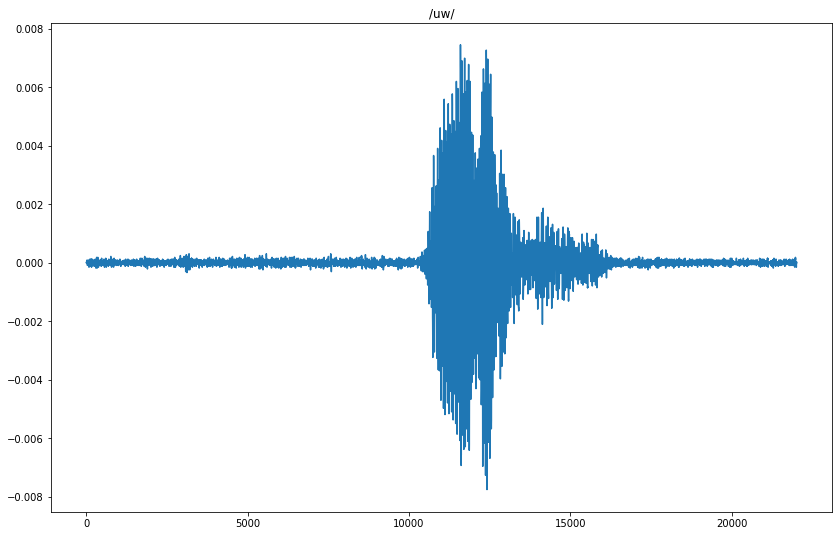

1.376


IndexError: list index out of range

In [5]:
for i in [0, 1]:
    example = dataset[i]
    plt.title(example["label"])
    plt.plot(example["audio_raw"])
    plt.show()
    print(len(example["audio_raw"]) / 16_000)

### Mel Spectrogram of Audio (Vocalised)

In [6]:
from matplotlib import cm

def plot_mel_spectrogram(mel_spec, title):
    fig, ax = plt.subplots(1)

    ax.set_title(f"Mel Spectogram \"{title}\"")
    pred = np.swapaxes(mel_spec, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    return fig

(135, 80)


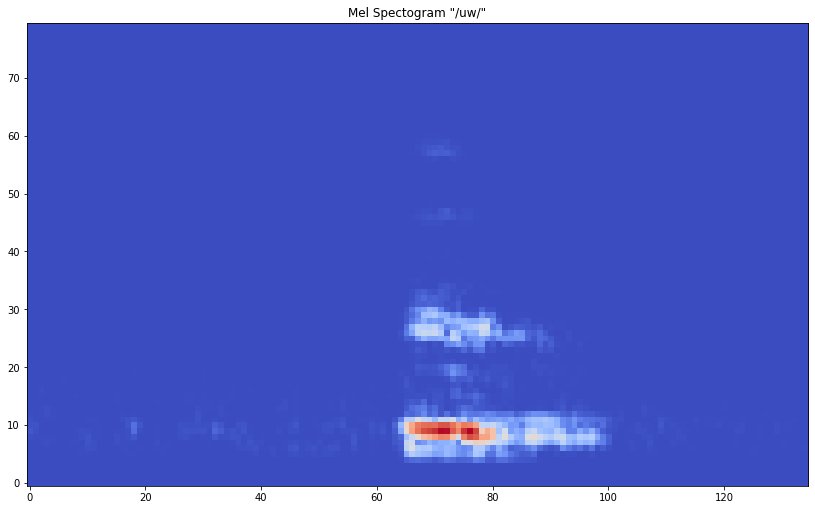

In [7]:
for i in [0]: # range(1):
    example_mel_spec = dataset[i]["audio_feats"]
    print(example_mel_spec.shape)
    plot_mel_spectrogram(example_mel_spec, dataset[i]["label"])

## Single Synthesis (Overfit)

### Model

In [35]:
import torch.nn as nn
import torch.nn.functional as F

from lib.transformer import *

class ProposedModel(nn.Module):
    def __init__(self,
                 model_size,
                 dropout=0.2,
                 num_layers=6,
                 n_heads=8,
                 dim_feedforward=3072,
                 out_dim=80,
                 use_resnet=False):
        super().__init__()
        self.use_resnet = use_resnet

        if use_resnet:
            self.conv_blocks = nn.Sequential(
                ResBlock(62, model_size, 2),
                ResBlock(model_size, model_size, 2),
                ResBlock(model_size, model_size, 2),
            )
            self.w_raw_in = nn.Linear(model_size, model_size)

        encoder_layer = TransformerEncoderLayer(
            d_model=model_size,
            nhead=n_heads,
            relative_positional=True,
            relative_positional_distance=100,
            dim_feedforward=dim_feedforward,
            dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.w_out = nn.Linear(model_size, out_dim)
    
    def forward(self, x):
        # (Optional) ResNet Blocks
        if self.use_resnet:
            # x shape is (batch, time, electrode)
            x = x.transpose(1, 2)
            x = self.conv_blocks(x)
            x = x.transpose(1, 2)
            x = self.w_raw_in(x)

        # Transformer
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)

        # Final MLP
        x = self.w_out(x)

        return x


class ResBlock(nn.Module):
    def __init__(self, num_ins, num_outs, stride=1):
        super().__init__()

        self.conv1 = nn.Conv1d(num_ins, num_outs, 3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm1d(num_outs)
        self.conv2 = nn.Conv1d(num_outs, num_outs, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_outs)

        if stride != 1 or num_ins != num_outs:
            self.residual_path = nn.Conv1d(num_ins, num_outs, 1, stride=stride)
            self.res_norm = nn.BatchNorm1d(num_outs)
        else:
            self.residual_path = None

    def forward(self, x):
        input_value = x

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        if self.residual_path is not None:
            res = self.res_norm(self.residual_path(input_value))
        else:
            res = input_value

        return F.relu(x + res)

In [58]:
# synth_examples = [dataset[0], dataset[1]]

synth_example = dataset[0]

import torch
import random

from lib.transduction import DigitalVoicingModel # , ProposedModel

electrode_slice = 62 # 62
ins = 5 * electrode_slice # 5 hand-crafted features * 62 electrodes
outs = 80 # n mels

device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model_type = "res-trans" # "transformer" # "res-trans"

if model_type == "lstm":
    model = DigitalVoicingModel(
        ins=ins,
        model_size=128,
        n_layers=2,
        dropout=0.0,
        outs=outs).to(device)
elif model_type == "transformer":
    model = ProposedModel(\
        model_size=ins,
        dropout=0.2,
        num_layers=8,
        n_heads=2,
        dim_feedforward=3072,
        out_dim=outs).to(device)
elif model_type == "res-trans":
    model_size = 768
    model = ProposedModel(\
        model_size=model_size,
        dropout=0.2,
        num_layers=8,
        n_heads=2,
        dim_feedforward=3072,
        out_dim=outs,
        use_resnet=True).to(device)

### Training

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

import matplotlib.pyplot as plt

print("MODEL TYPE:", model_type)

X = torch.tensor(synth_example["eeg_vocal_raw"], dtype=torch.bfloat16).to(device)
y = torch.tensor(synth_example["audio_feats"],   dtype=torch.bfloat16).to(device)

# clip sizes to smallest of both
clip_len = min(X.shape[0], y.shape[0])

# X = X[:clip_len, :ins]
y = y[:clip_len, :]

print("X SHAPE, Y SHAPE:", X.shape, y.shape)

X = torch.unsqueeze(X, 0)
y = torch.unsqueeze(y, 0)

# NOTE: 5e-4 at 20,000 epochs for vocal, 1e-3 at 10,000 epochs for imagined
lr = 5e-4 # 1e-3 # 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

epochs = 20_000 # 10_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000, gamma=0.1)

for i in range(epochs):
    # optim.zero_grad()

    with torch.autocast(
        enabled=amp,
        dtype=torch.bfloat16,
        device_type=device):

        #print("model inp:", X.shape, X.dtype)

        pred = model(X)

        #print("model outp:", pred.shape, pred.dtype)

        if y.shape[1] < pred.shape[1]:
            pred = pred[:, :y.shape[1], :]
            #print("model outp (clipped):", pred.shape, pred.dtype)
            #print("y:", y.shape)

        loss = criteria(pred, y)

        if i % 100 == 0:
            pred_s.append(pred.cpu().detach())
            losses.append(loss.item())

        # plt.plot(loss.item())

            print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

MODEL TYPE: res-trans
X SHAPE, Y SHAPE: torch.Size([1204, 62]) torch.Size([135, 80])
0 131.83074951171875
100 0.21593858301639557
200 0.2126515507698059
300 0.2080298811197281
400 0.20504847168922424
500 0.19200991094112396
600 0.18981444835662842
700 0.20107565820217133
800 0.19432182610034943
900 0.1905161291360855
1000 0.18946723639965057
1100 0.19253435730934143
1200 0.18997468054294586
1300 0.1977517306804657


KeyboardInterrupt: 

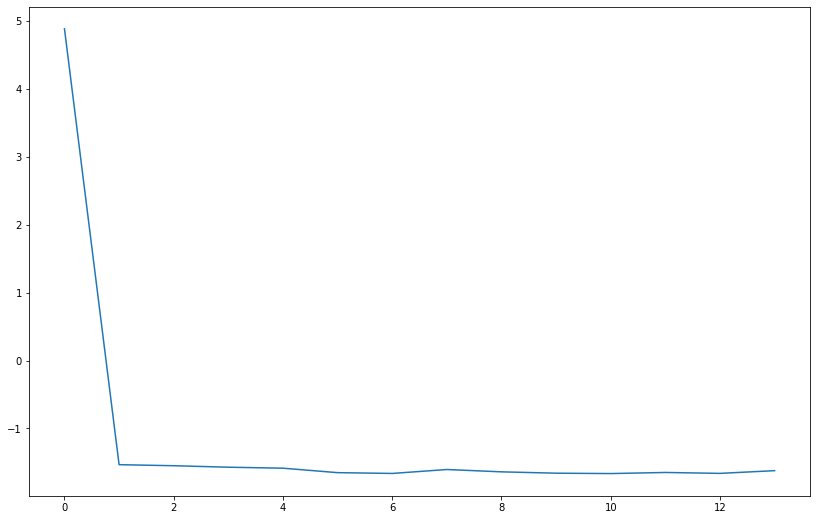

In [60]:
plt.plot(np.log(losses))

### Plot Pred

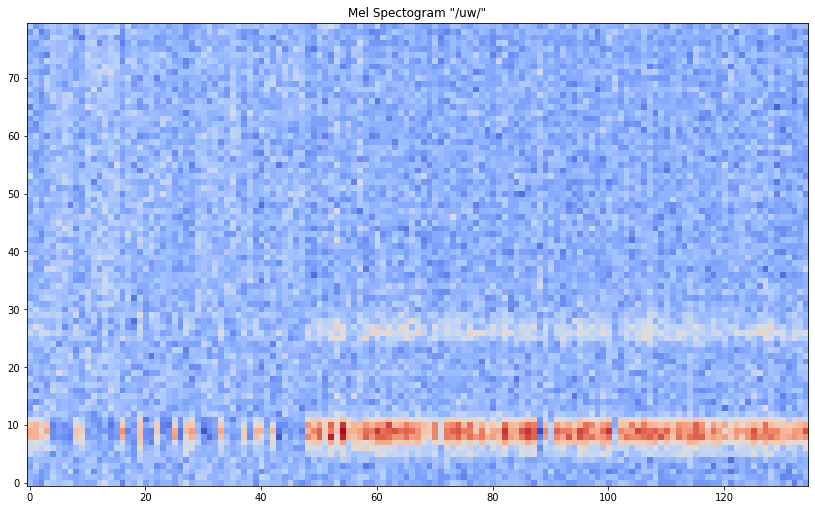

In [61]:
plt.rcParams["figure.figsize"] = (14, 9)

y = torch.squeeze(pred_s[len(pred_s) - 1], 0).float()
_ = plot_mel_spectrogram(y, synth_example["label"])

### Plot Original

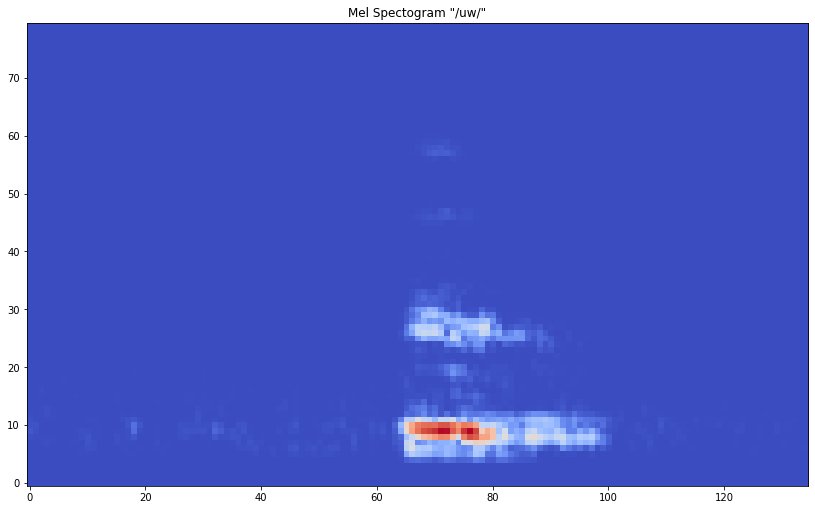

In [62]:
cur_ex = dataset[0]
_ = plot_mel_spectrogram(cur_ex["audio_feats"], cur_ex["label"])

## Multiple Synthesis (Overfit)

### Model

In [35]:
%%capture ignore

# Ignore data sample loading text

import torch
import random

from lib.transduction import DigitalVoicingModel

target_labels = ["/n/"]
synth_examples = [data for data in dataset if data["label"] in target_labels]
#synth_examples = [data for data in dataset]
#synth_examples = synth_examples[0:len(synth_examples)] # [:105]
[print(eg["label"]) for eg in synth_examples]

ratio = 0.8
pivot_point = int(len(synth_examples) * 0.8)
synth_examples = synth_examples[0:pivot_point]

electrode_slice = 62 # 62
ins = 5 * electrode_slice # 5 hand-crafted features * 62 electrodes
outs = 80 # n mels

device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = DigitalVoicingModel(
    ins=ins,
    model_size=64,
    n_layers=1,
    dropout=0.0,
    outs=outs).to(device)

### Training

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

import matplotlib.pyplot as plt

X_s = []
y_s = []

for synth_example in synth_examples:
    X = torch.tensor(synth_example["eeg_vocal_feats"]).to(device)
    # X = torch.tensor(synth_example["eeg_active_feats"]).to(device)
    y = torch.tensor(synth_example["audio_feats"]).to(device)
    clip_len = min(X.shape[0], y.shape[0])
    X = X[:clip_len, :ins]
    y = y[:clip_len, :]
    X = torch.unsqueeze(X, 0)
    y = torch.unsqueeze(y, 0)
    X_s.append(X)
    y_s.append(y)

# NOTE: 5e-4 for vocal EEG looked promising, try running for longer if ReduceLROnPlateau doesn't work
# NOTE: 1e-3 (0-1500), 5e-4 (1500-3000), 5e-4 (3000-4500)
lr = 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

# 20_000
epochs = 10_000 # 20_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1500, gamma=0.5)

model.train()

for i in range(epochs):
    # optim.zero_grad()

    cur_losses = []

    for X, y in zip(X_s, y_s):
        with torch.autocast(
            enabled=amp,
            dtype=torch.bfloat16,
            device_type=device):

            pred = model(X) 
            loss = criteria(pred, y)
            cur_losses.append(loss)
    
    loss = sum(cur_losses)

    if i % 100 == 0:
        losses.append(loss.item())
        print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

0 1555.8955078125
100 215.10848999023438
200 14.534089088439941
300 6.474761009216309


KeyboardInterrupt: 

### Testing

In [10]:
out_s = []

model.eval()

for X, y in zip(X_s, y_s):
    with torch.no_grad():
        pred = model(X)
        out_s.append(pred.cpu().detach())

([<matplotlib.lines.Line2D at 0x1ca3b3963d0>], 12)

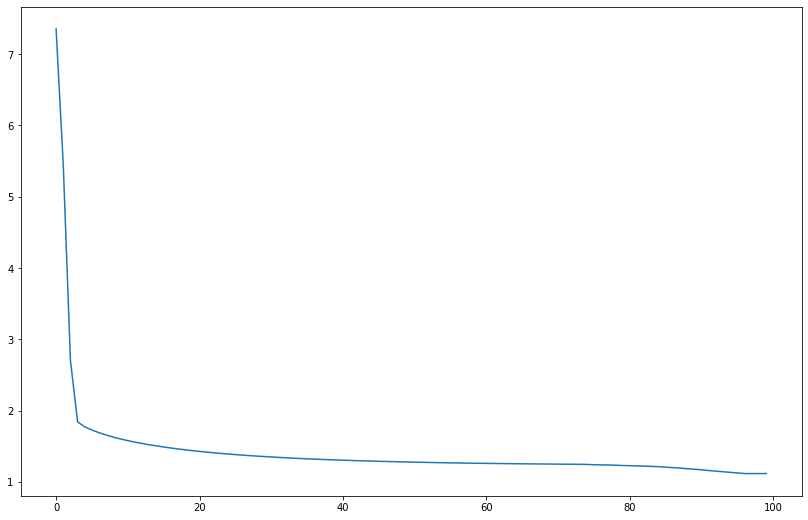

In [11]:
plt.plot(np.log(losses)), len(out_s)

### Plot Pred

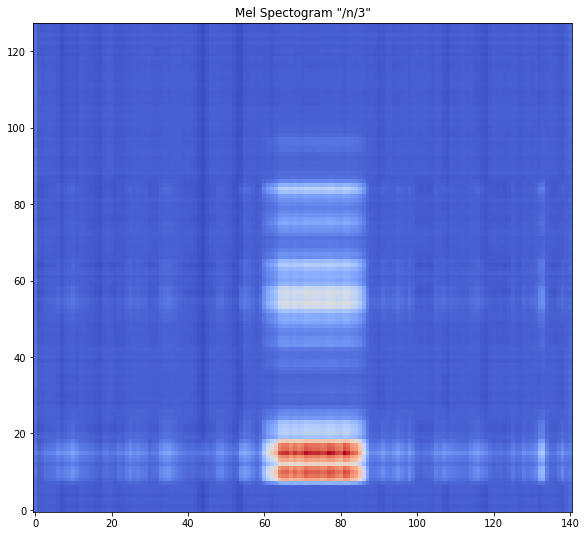

In [42]:
plt.rcParams["figure.figsize"] = (14, 9)

plot_pred_idx = 3
y = torch.squeeze(out_s[plot_pred_idx], 0).float()
_ = plot_mel_spectrogram(y, synth_examples[plot_pred_idx]["label"] + str(plot_pred_idx))

### Plot Original

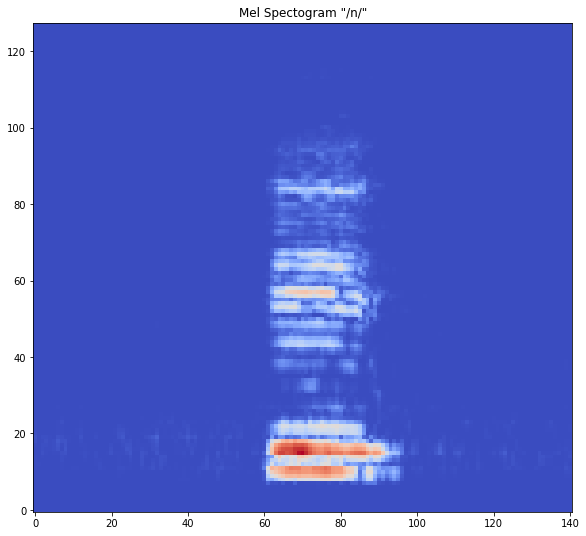

In [43]:
_ = plot_mel_spectrogram(synth_examples[plot_pred_idx]["audio_feats"], synth_examples[plot_pred_idx]["label"])

## Single Phoneme/Word Synthesis (Generalisation)

### Model

In [9]:
%%capture ignore

# Ignore data sample loading text

import torch
import random

from lib.transduction import DigitalVoicingModel, ProposedModel

target_labels = ['/m/', '/n/']
# target_labels = ['/uw/', '/tiy/', '/iy/', '/m/', '/n/', '/piy/', '/diy/']
synth_examples_s = [[data for data in dataset if data["label"] in target_label]
                    for target_label in target_labels]

#synth_examples = [data for data in dataset]
#synth_examples = synth_examples[0:len(synth_examples)] # [:105]
[[print(eg["label"]) for eg in synth_examples]
 for synth_examples in synth_examples_s]

flatten = lambda lst: [item for sublist in lst for item in sublist]
ratio = 0.8
pivot_point = int(len(synth_examples_s[0]) * ratio)

trainset = [synth_examples[0:pivot_point]
            for synth_examples in synth_examples_s]
trainset = flatten(trainset)
testset  = [synth_examples[pivot_point:]
            for synth_examples in synth_examples_s]
testset  = flatten(testset)

electrode_slice = 62 # 62
ins = 5 * electrode_slice # 5 hand-crafted features * 62 electrodes
outs = 80 # 128 # n mels # 80 for waveglow

device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model_type = "transformer" # "transformer"

if model_type == "lstm":
    model_size = 128
    n_layers = 2
    dropout = 0.5

    model = DigitalVoicingModel(
        ins=ins,
        model_size=model_size,
        n_layers=n_layers,
        dropout=dropout,
        outs=outs).to(device)

elif model_type == "transformer":
    model_size=ins
    n_layers = 4
    dropout = 0.2
    n_heads = 5

    model = ProposedModel(\
        model_size=ins,
        dropout=dropout,
        num_layers=n_layers,
        n_heads=n_heads,
        dim_feedforward=3072,
        out_dim=outs).to(device)

### Train

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

import matplotlib.pyplot as plt

# Logging
from dotenv import dotenv_values
import neptune.new as neptune

config = dotenv_values(".env")

data_only = False

if not data_only:
    run = neptune.init(project=config["NEPTUNE_PROJECT"], api_token=config["NEPTUNE_TOKEN"])

EEG_TYPE = "vocal"

def fillset(synth_examples):
    X_s = []
    y_s = []
    for synth_example in synth_examples:
        if EEG_TYPE == "vocal":
            X = torch.tensor(synth_example["eeg_vocal_feats"]).to(device)
        elif EEG_TYPE == "imagined":
            X = torch.tensor(synth_example["eeg_active_feats"]).to(device)
        else:
            ValueError(f"{EEG_TYPE} is invalid!")
        y = torch.tensor(synth_example["audio_feats"]).to(device)
        clip_len = min(X.shape[0], y.shape[0])
        X = X[:clip_len, :ins]
        y = y[:clip_len, :]
        X = torch.unsqueeze(X, 0)
        y = torch.unsqueeze(y, 0)
        X_s.append(X)
        y_s.append(y)
    return X_s, y_s

train_X_s, train_y_s = fillset(trainset)
test_X_s,  test_y_s  = fillset(testset)

lr = 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

epochs = 5_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s  = []
losses  = []
vlosses = []

params = {
    "initial_lr": lr,
    "optimizer": optim.__class__,
    "amp": amp,
    "target_labels": target_labels,
    "eeg_type": EEG_TYPE,
    "in_dim": ins,
    "out_dim": outs,
    "lstm_hidden_dim": model_size,
    "lstm_layers": n_layers,
    "random_seed": seed,
    "epochs": epochs,
    "model_type": model_type
}

# Add transformer specific logging
if n_heads:
    learning_rate_patience = 5
    params = {**params, **{
        "n_heads": n_heads,
        "learning_rate_patience": learning_rate_patience
    }}

if not data_only:
    run["parameters"] = params

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def test(model):
    model.eval()

    cur_losses = []

    for X, y in zip(test_X_s, test_y_s):
        with torch.no_grad():
            pred = model(X)
            loss = criteria(pred, y)
            cur_losses.append(loss)

    loss = sum(cur_losses)

    return loss.item()

def train(model, scheduler):
    model.train()

    # optim.zero_grad()

    cur_losses = []

    for X, y in zip(train_X_s, train_y_s):
        with torch.autocast(
            enabled=amp,
            dtype=torch.bfloat16,
            device_type=device):

            pred = model(X) 
            loss = criteria(pred, y)
            cur_losses.append(loss)
    
    loss = sum(cur_losses)

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    if scheduler:
        scheduler.step()

    return loss.item()

def go(model):
    # scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, 'min', 0.5, patience=learning_rate_patience)
    scheduler = None

    min_mean_vloss = float("inf")

    for i in range(epochs):
        train_loss = train(model, scheduler)
        
        if i % 100 == 0:
            losses.append(train_loss)
            test_loss = test(model)
            vlosses.append(test_loss)
            run["loss"].log(train_loss)
            run["mean_loss"].log(train_loss / len(trainset))
            run["vloss"].log(test_loss)
            run["mean_vloss"].log(test_loss / len(testset))
            run["current_lr"].log(get_lr(optim))
            print(i, train_loss, test_loss)

            # sanitise phoneme tokens for model checkpoint filename
            out_target_labels = [label[1:-1] if label[0] == "/" else label
                                 for label in target_labels]
            label_str = "_".join(out_target_labels)
            cur_mean_vloss = test_loss / len(testset)

            if cur_mean_vloss < min_mean_vloss:
                torch.save(model.state_dict(), f"./models/{label_str}_{EEG_TYPE}_{i}_epochs_{cur_mean_vloss}_mean_vloss.pt")
                min_mean_vloss = cur_mean_vloss

    #label_str = "_".join(target_labels)
    #mean_vloss = test_loss / len(testset)
    #torch.save(model.state_dict(), f"./models/{label_str}_{EEG_TYPE}_20000_epochs_{mean_vloss}_mean_vloss.pt")

if not data_only:
    go(model)
    run.stop()


https://app.neptune.ai/miscellaneousstuff/imagined-speech-synth-transformer/e/IM2-12
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
0 3085.628173828125 663.0517578125
100 7.989145278930664 1.856568694114685
Run IM2-1 received stop signal. Exiting
Shutting down background jobs, please wait a moment...
Run IM2-2 received stop signal. Exiting
Run IM2-4 received stop signal. Exiting
Shutting down background jobs, please wait a moment...
Shutting down background jobs, please wait a moment...
Done!
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
Run IM2-9 received stop signal. Exiti

: 

: 

In [82]:
model.load_state_dict(torch.load("./models/transformer/m_n_vocal_600_epochs_0.2335327466328939_mean_vloss.pt"))

<All keys matched successfully>

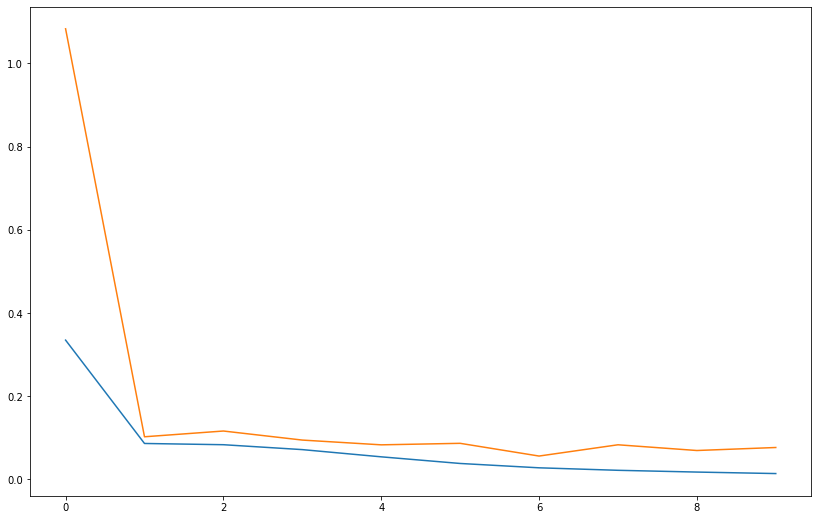

In [83]:
plt.plot(np.log(losses) / len(trainset))
plt.plot(np.log(vlosses) / len(testset))

#### Generate Predictions

In [84]:
out_s = []

model.eval()

view_X_s, view_y_s = test_X_s, test_y_s

for X, y in zip(view_X_s, view_y_s):
    with torch.no_grad():
        pred = model(X)
        out_s.append(pred.cpu().detach())

#### Plot Prediction

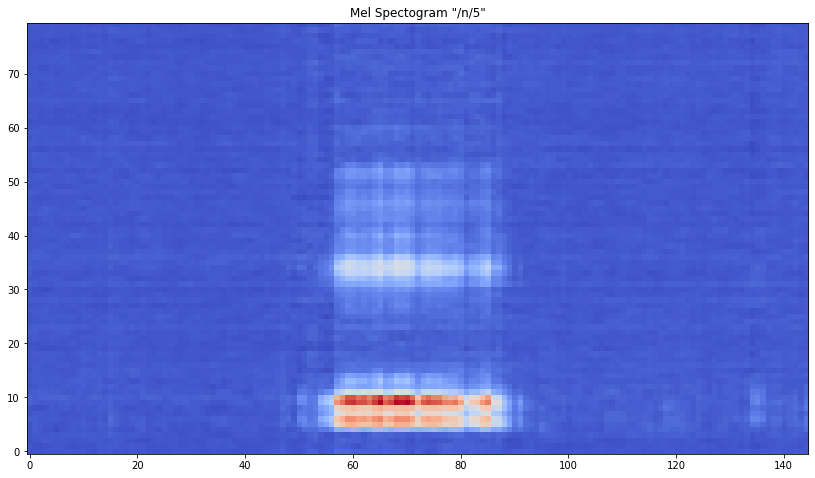

In [89]:
plt.rcParams["figure.figsize"] = (14, 9)

viewset = testset

plot_pred_idx = 5
y = torch.squeeze(out_s[plot_pred_idx], 0).float()
_ = plot_mel_spectrogram(y, viewset[plot_pred_idx]["label"] + str(plot_pred_idx))

#### Plot Original

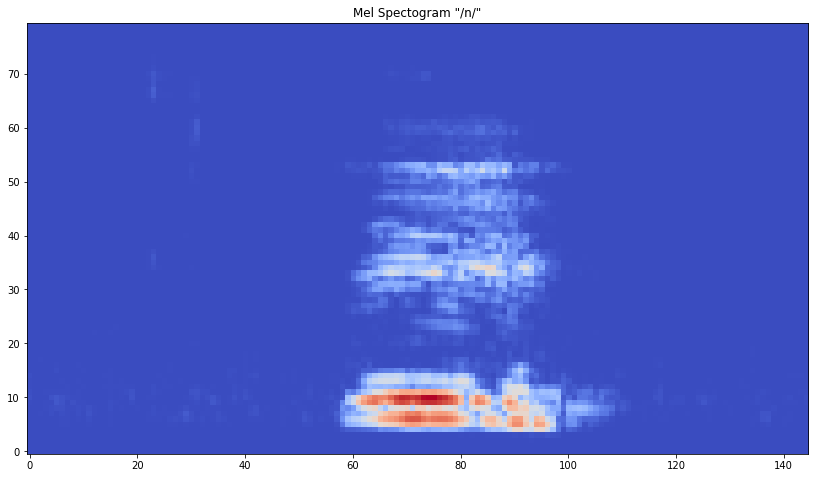

In [90]:
_ = plot_mel_spectrogram(
    viewset[plot_pred_idx]["audio_feats"],
    viewset[plot_pred_idx]["label"])

#### Save Prediction (for WaveGlow)

In [56]:
mel_to_save = torch.squeeze(out_s[plot_pred_idx], 0)[:, 0:80].float()
# mel_to_save = viewset[plot_pred_idx]["audio_feats"]
mel_to_save = torch.tensor(mel_to_save)
mel_fname   = viewset[plot_pred_idx]["label"]
mel_fname   = mel_fname[1:-1] if mel_fname[0] == "/" else mel_fname
mel_fname   = f"{mel_fname}_pred.pt"
torch.save(mel_to_save.T, mel_fname)

C:\Users\win8t\AppData\Local\Temp/ipykernel_9884/193063567.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_to_save = torch.tensor(mel_to_save)


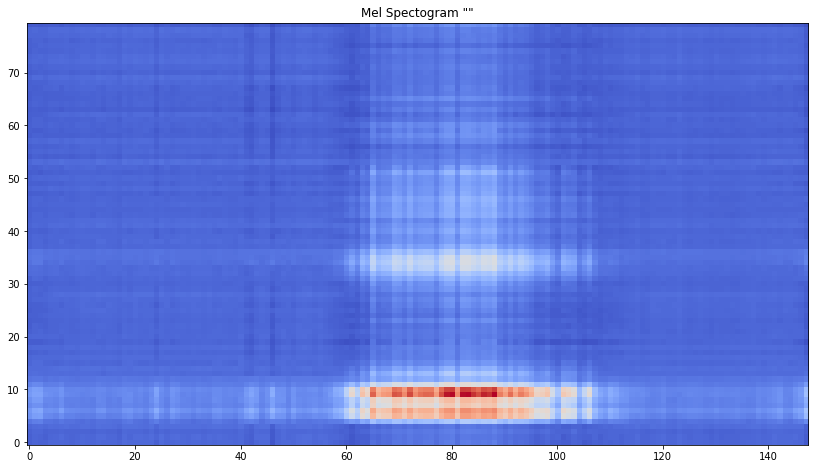

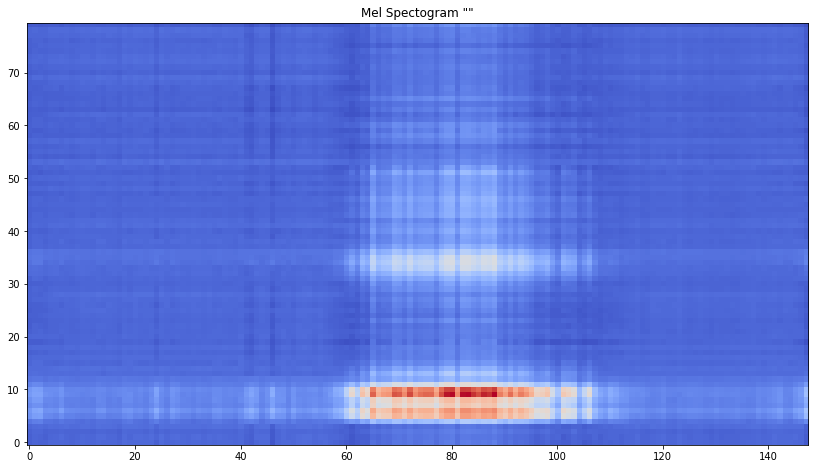

In [57]:
plot_mel_spectrogram(mel_to_save, "")

#### Visualise Vocoded Audio

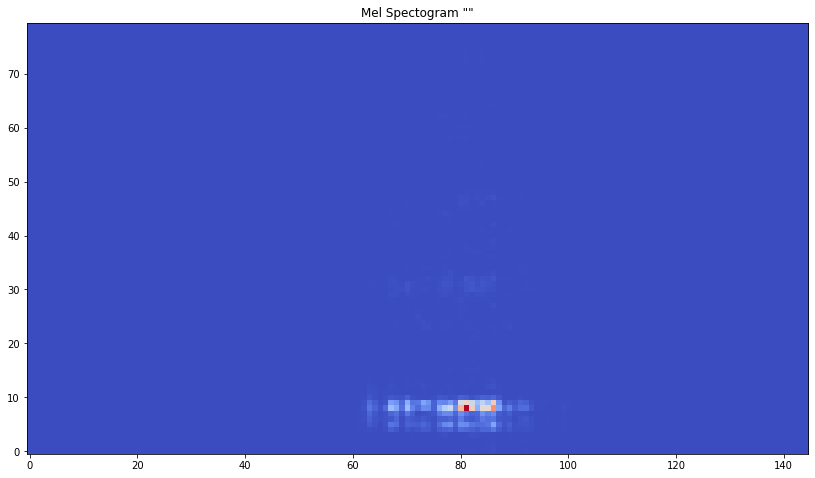

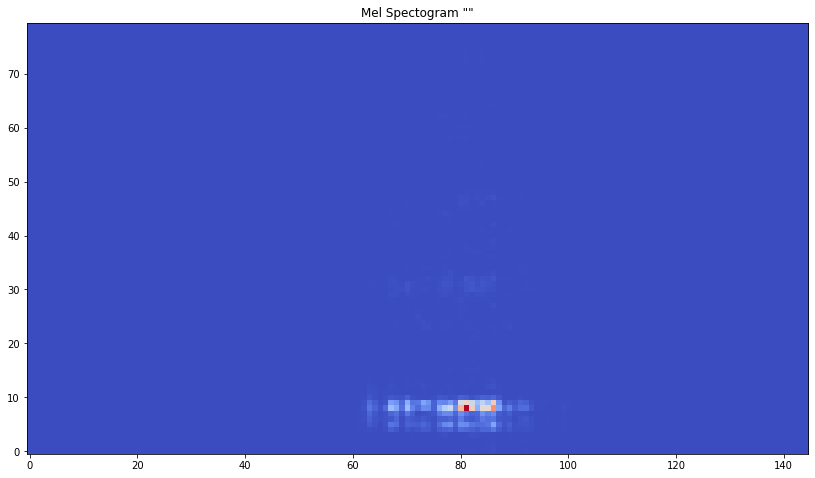

In [58]:
import soundfile as sf
from lib import load_audio
import librosa
n_mel_channels = 80

vocoded_audio_fname = "m_pred_synthesis.wav"
audio, r = sf.read(vocoded_audio_fname)
audio_features = librosa.feature.melspectrogram(
        audio,
        sr=r,
        n_mels=n_mel_channels,
        center=False,
        n_fft=1024,
        win_length=1024,
        hop_length=256).T
audio_features = np.log(audio_features + 1e-5)
plot_mel_spectrogram(audio_features, "")

#### Visualise Any Predicted Mel Spectrogram

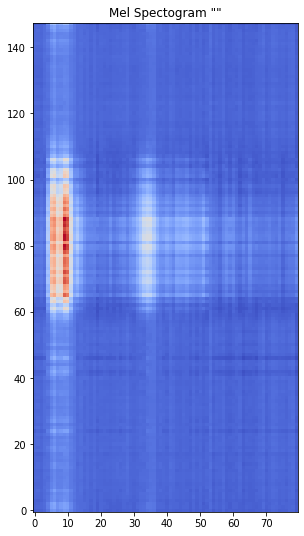

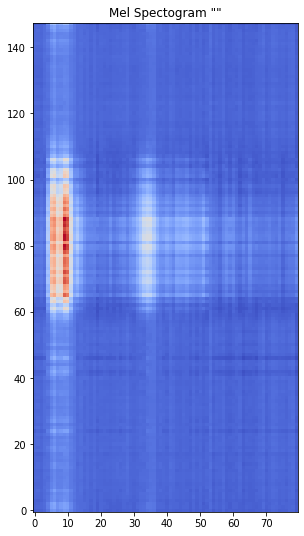

In [59]:
audio_data = torch.load("m_pred.pt")
plot_mel_spectrogram(audio_data, "")